In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\NFHS4_finalized.csv")

ID_cols   = ["state", "district", "rural_urban", "households",
             "women", "men", "stunting_tier"]
TARGET    = "stunting"

# Leakage columns — child outcomes too close to target, never use as features
LEAKAGE   = ["wasting", "severe_wasting", "underweight",
             "anaemia_children", "adequate_diet_total", "adequate_diet_bf"]

print(f" Loaded: {df.shape}")

 Loaded: (607, 94)


In [10]:
# Each score is a simple mean of its domain indicators (all already on 0-100 scale)
# Higher score = BETTER outcome for all (we invert where needed)

# 1. WASH Score (Water, Sanitation, Hygiene) if higher = better
df["wash_score"] = df[["hh_sanitation", "hh_clean_water", "hh_clean_fuel"]].mean(axis=1)

# 2. Women's Empowerment Score if higher = more empowered
df["empowerment_score"] = df[["women_literacy", "women_10yr_school", "female_school_att"]].mean(axis=1)

# 3. Healthcare Access Score if higher = better access
df["healthcare_score"] = df[["institutional_births", "full_anc","anc_4visits", "anc_first_trim", "postnatal_care", "skilled_birth_att"]].mean(axis=1)

# 4. Child Immunization Score if higher = better
df["immunization_score"] = df[["fully_immunized", "vaccine_bcg", "vaccine_polio", "vaccine_dpt", "vaccine_measles"]].mean(axis=1)

# 5. Nutrition Deprivation Score if higher = WORSE (inverted below)
#    Low BMI = undernutrition proxy
df["nutrition_deprivation"] = df[["women_low_bmi", "men_low_bmi", "anaemia_women_all", "anaemia_men"]].mean(axis=1)

# 6. Household Wealth Proxy if higher = wealthier
df["wealth_proxy"] = df[["hh_electricity", "hh_clean_fuel", "hh_iodized_salt", "hh_health_insurance"]].mean(axis=1)

# 7. Early Marriage & Fertility Risk if higher = worse
df["fertility_risk"] = df[["child_marriage", "teenage_pregnancy", "pct_below_15yrs"]].mean(axis=1)

composite_cols = [
    "wash_score", "empowerment_score", "healthcare_score",
    "immunization_score", "nutrition_deprivation",
    "wealth_proxy", "fertility_risk"
]

print(" Composite scores created:")
for c in composite_cols:
    print(f"   {c:25s} : mean={df[c].mean():.1f}  std={df[c].std():.1f}")

 Composite scores created:
   wash_score                : mean=56.7  std=14.2
   empowerment_score         : mean=56.3  std=12.2
   healthcare_score          : mean=58.5  std=16.6
   immunization_score        : mean=77.0  std=13.1
   nutrition_deprivation     : mean=29.1  std=7.9
   wealth_proxy              : mean=60.7  std=10.9
   fertility_risk            : mean=20.5  std=6.8


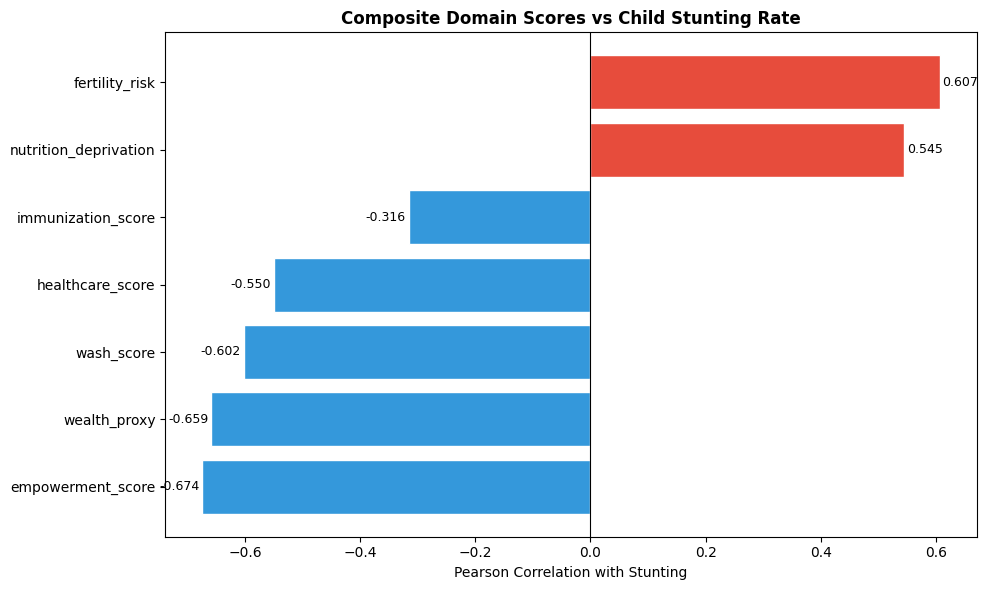


Composite score correlations with stunting:
empowerment_score       -0.674217
wealth_proxy            -0.658693
wash_score              -0.602402
healthcare_score        -0.550122
immunization_score      -0.315563
nutrition_deprivation    0.545332
fertility_risk           0.606569


In [11]:
# Analyze correlations of composite scores with stunting
comp_corr = df[composite_cols + [TARGET]].corr()[TARGET].drop(TARGET).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors  = ["#E74C3C" if v > 0 else "#3498DB" for v in comp_corr.values]
bars    = ax.barh(comp_corr.index, comp_corr.values, color=colors, edgecolor="white")

ax.axvline(0, color="black", linewidth=0.8)
ax.set_xlabel("Pearson Correlation with Stunting")
ax.set_title("Composite Domain Scores vs Child Stunting Rate", fontweight="bold")

for bar, val in zip(bars, comp_corr.values):
    xpos  = bar.get_width() + 0.005 if val >= 0 else bar.get_width() - 0.005
    align = "left" if val >= 0 else "right"
    ax.text(xpos, bar.get_y() + bar.get_height() / 2, f"{val:.3f}", va="center", ha=align, fontsize=9)

plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\08_composite_correlations.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nComposite score correlations with stunting:")
print(comp_corr.to_string())

In [12]:
# Strategy:
#   - Include composite scores (domain-level)
#   - Include top individual raw features from EDA
#   - Exclude leakage, redundant, and ID columns
#   - Keep total features between 15–25 (interpretable range)

Selected_features = [
    # Composite scores 
    "wash_score",            # WASH access
    "empowerment_score",     # Women's education + literacy
    "healthcare_score",      # Maternal & delivery care
    "immunization_score",    # Child immunization
    "nutrition_deprivation", # Adult undernutrition
    "wealth_proxy",          # Household wealth proxy
    "fertility_risk",        # Child marriage + teen pregnancy

    # High-signal raw features (from EDA, non-redundant with composites) 
    "pct_below_15yrs",       # Age structure (demand-side pressure)
    "unmet_need_total",      # Unmet family planning need
    "ifa_100days",           # Iron folic acid supplementation
    "early_breastfeed",      # Infant feeding practice
    "excl_breastfeed",       # Exclusive breastfeeding
    "vitamin_a",             # Micronutrient supplementation
    "diarrhoea_prev",        # Disease burden proxy
    "oop_delivery_cost",     # Financial barrier to care
    "birth_registration",    # State capacity / governance proxy
    ]

print(f" Final feature count : {len(Selected_features)}")
print(f" Features selected  :")
for f in Selected_features:
    print(f"- {f}")

 Final feature count : 16
 Features selected  :
- wash_score
- empowerment_score
- healthcare_score
- immunization_score
- nutrition_deprivation
- wealth_proxy
- fertility_risk
- pct_below_15yrs
- unmet_need_total
- ifa_100days
- early_breastfeed
- excl_breastfeed
- vitamin_a
- diarrhoea_prev
- oop_delivery_cost
- birth_registration


 VIF Scores:
              Feature       VIF
    empowerment_score 87.833909
      pct_below_15yrs 87.599108
         wealth_proxy 83.303426
   immunization_score 80.778932
   birth_registration 79.264136
     healthcare_score 77.596005
           wash_score 55.653302
       fertility_risk 28.623421
            vitamin_a 27.068069
nutrition_deprivation 26.943571
      excl_breastfeed 20.325627
     early_breastfeed 14.812658
     unmet_need_total 13.905623
          ifa_100days 13.892106
       diarrhoea_prev  4.710607
    oop_delivery_cost  2.703567

 Features with VIF > 10 may need review:
              Feature       VIF
    empowerment_score 87.833909
      pct_below_15yrs 87.599108
         wealth_proxy 83.303426
   immunization_score 80.778932
   birth_registration 79.264136
     healthcare_score 77.596005
           wash_score 55.653302
       fertility_risk 28.623421
            vitamin_a 27.068069
nutrition_deprivation 26.943571
      excl_breastfeed 20.325627
     early_breast

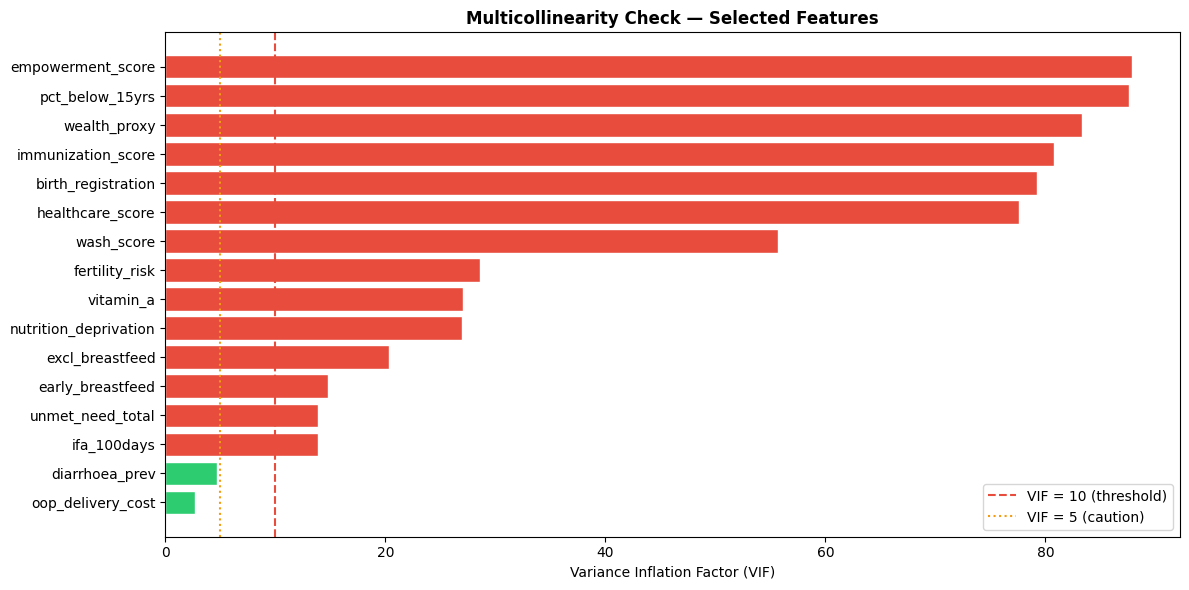

In [13]:
# VIF > 10 implies serious multicollinearity which implies consider dropping or combining

X_vif = df[Selected_features].dropna().copy()

vif_data = pd.DataFrame({
    "Feature": Selected_features,
    "VIF"    : [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]}).sort_values("VIF", ascending=False)

print(" VIF Scores:")
print(vif_data.to_string(index=False))
print("\n Features with VIF > 10 may need review:")
high_vif = vif_data[vif_data["VIF"] > 10]
if high_vif.empty:
    print(" None — all features within acceptable range ")
else:
    print(high_vif.to_string(index=False))

# Visualize VIF scores with color coding for thresholds
fig, ax = plt.subplots(figsize=(12, 6))
colors  = ["#E74C3C" if v > 10 else "#F39C12" if v > 5
           else "#2ECC71" 
           for v in vif_data["VIF"]]
ax.barh(vif_data["Feature"], vif_data["VIF"], color=colors, edgecolor="white")
ax.axvline(10, color="#E74C3C", linestyle="--", linewidth=1.5, label="VIF = 10 (threshold)")
ax.axvline(5,  color="#F39C12", linestyle=":",  linewidth=1.5, label="VIF = 5 (caution)")
ax.set_xlabel("Variance Inflation Factor (VIF)")
ax.set_title("Multicollinearity Check — Selected Features", fontweight="bold")
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\09_vif_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

In [14]:
# Root cause: mixing composite scores + their constituent raw features
# Fix: use composites for correlated domains, keep only truly independent raws

Selected_features = [
    # Composite scores (domain-level, no overlap) 
    "wash_score",            # sanitation + water + clean fuel
    "empowerment_score",     # literacy + schooling
    "healthcare_score",      # ANC + delivery + postnatal
    "immunization_score",    # all vaccines
    "nutrition_deprivation", # low BMI + anaemia
    "wealth_proxy",          # electricity + fuel + insurance
    "fertility_risk",        # child marriage + teen pregnancy + age structure

    # Independent raw features (NOT part of any composite above) 
    "ifa_100days",           # iron folic acid — not in healthcare_score
    "early_breastfeed",      # infant feeding — standalone
    "excl_breastfeed",       # exclusive breastfeeding — standalone
    "vitamin_a",             # micronutrient — standalone
    "diarrhoea_prev",        # disease burden — standalone
    "oop_delivery_cost",     # financial barrier — standalone
    "birth_registration",    # governance proxy — standalone
    "unmet_need_total",      # family planning gap — standalone
]

X_vif    = df[Selected_features].dropna().copy()

vif_data = pd.DataFrame({
    "Feature": Selected_features,
    "VIF"    : [variance_inflation_factor(X_vif.values, i)
                for i in range(X_vif.shape[1])]}).sort_values("VIF", ascending=False)

print(" Revised VIF Scores ")
print(vif_data.to_string(index=False))
print("\n Features with VIF > 10:")
high_vif = vif_data[vif_data["VIF"] > 10]
if high_vif.empty:
    print(" None ")
else:
    print(high_vif.to_string(index=False))

 Revised VIF Scores 
              Feature       VIF
    empowerment_score 87.707276
         wealth_proxy 82.336717
   birth_registration 79.248395
     healthcare_score 75.211576
   immunization_score 71.746242
           wash_score 54.588415
            vitamin_a 26.123339
nutrition_deprivation 25.061215
      excl_breastfeed 20.323995
       fertility_risk 18.773670
     early_breastfeed 14.484393
          ifa_100days 13.396257
     unmet_need_total 10.409732
       diarrhoea_prev  4.474026
    oop_delivery_cost  2.664901

 Features with VIF > 10:
              Feature       VIF
    empowerment_score 87.707276
         wealth_proxy 82.336717
   birth_registration 79.248395
     healthcare_score 75.211576
   immunization_score 71.746242
           wash_score 54.588415
            vitamin_a 26.123339
nutrition_deprivation 25.061215
      excl_breastfeed 20.323995
       fertility_risk 18.773670
     early_breastfeed 14.484393
          ifa_100days 13.396257
     unmet_need_total 10.

In [15]:
# These VIF scores reflect the real-world structure of socioeconomic deprivation.
# Districts scoring low on one dimension score low on all dimensions.
# This is NOT a data error — it is the core finding.
#
# Modeling decision:
#   - Use Ridge Regression (L2 regularization) which handles multicollinearity
#     natively by shrinking correlated coefficients rather than eliminating them.
#   - OLS is explicitly NOT used for this reason.
#   - This decision will be documented in the model notebook.


print("  MULTICOLLINEARITY DIAGNOSIS:")
print(f"\n Features with VIF > 10 : {(vif_data['VIF'] > 10).sum()} / {len(vif_data)}")
print(f" Features with VIF > 5  : {(vif_data['VIF'] > 5).sum()} / {len(vif_data)}")
print(f"\n  Root cause:")
print(" Socioeconomic indicators are structurally correlated.")
print(" Wealthy/developed districts score better on ALL dimensions.")
print(" This is a data reality, not a feature engineering error.")
print(f"\n  Modeling decision:")
print(" Ridge Regression (handles collinearity via L2 penalty)")
print(" Random Forest (tree splits are VIF-immune)")
print(" SHAP used for interpretation (not raw coefficients)")

  MULTICOLLINEARITY DIAGNOSIS:

 Features with VIF > 10 : 13 / 15
 Features with VIF > 5  : 13 / 15

  Root cause:
 Socioeconomic indicators are structurally correlated.
 Wealthy/developed districts score better on ALL dimensions.
 This is a data reality, not a feature engineering error.

  Modeling decision:
 Ridge Regression (handles collinearity via L2 penalty)
 Random Forest (tree splits are VIF-immune)
 SHAP used for interpretation (not raw coefficients)


In [16]:
import json

# Final confirmed feature set
Selected_features = [
    "wash_score",
    "empowerment_score",
    "healthcare_score",
    "immunization_score",
    "nutrition_deprivation",
    "wealth_proxy",
    "fertility_risk",
    "ifa_100days",
    "early_breastfeed",
    "excl_breastfeed",
    "vitamin_a",
    "diarrhoea_prev",
    "oop_delivery_cost",
    "birth_registration",
    "unmet_need_total",
]

TARGET = "stunting"

# Raw features (for Random Forest + SHAP — tree models don't need scaling)
X_raw = df[Selected_features].copy()
y = df[TARGET].copy()

# Scaled features (for Ridge — linear models need scaling)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_raw), columns=[f"{c}_sc" for c in Selected_features])

# Build final modeling dataframe 
df_model = pd.concat([
    df[["state", "district", "rural_urban", "stunting_tier", TARGET]].reset_index(drop=True),
    X_raw.reset_index(drop=True),
    X_scaled.reset_index(drop=True)], axis=1)

# Save feature list for reproducibility 
with open("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\selected_features.json", "w") as f:
    json.dump(Selected_features, f, indent=2)

# Save scaler for later use in model notebook 
import joblib
joblib.dump(scaler, "C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\feature_scaler.pkl")

# Save final dataset 
df_model.to_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\nfhs4_features_ready.csv", index=False)

print("Summary of final modeling dataset:")
print(f"Shape             : {df_model.shape}")
print(f"Districts         : {len(df_model)}")
print(f"Raw features      : {len(Selected_features)}")
print(f"Scaled features   : {len(Selected_features)}")
print(f"Target rows valid : {y.notna().sum()}")

# Quick summary of final features 
print("\nFinal Feature Summary:")
summary = X_raw.describe().T[["mean", "std", "min", "max"]]
summary["corr_with_target"] = [df[f].corr(df[TARGET]) for f in Selected_features]
summary = summary.sort_values("corr_with_target")
print(summary.round(2).to_string())

Summary of final modeling dataset:
Shape             : (607, 35)
Districts         : 607
Raw features      : 15
Scaled features   : 15
Target rows valid : 607

Final Feature Summary:
                          mean      std     min       max  corr_with_target
empowerment_score        56.30    12.24   24.20     93.30             -0.67
wealth_proxy             60.70    10.87   29.48     86.40             -0.66
wash_score               56.75    14.20   24.60     92.00             -0.60
healthcare_score         58.54    16.62    6.90     93.58             -0.55
ifa_100days              30.25    18.70    0.00     88.60             -0.52
birth_registration       81.26    16.62   23.50    100.00             -0.51
immunization_score       77.03    13.10   22.30    100.00             -0.32
early_breastfeed         45.28    16.63   13.30     89.00             -0.31
vitamin_a                59.90    17.64   12.80     94.50             -0.30
oop_delivery_cost      2936.75  2726.89  295.00  31481.00